In [10]:
# Loading all Modules #
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.backend import tf
from scipy import interpolate
print(tf.__version__)

2.7.0


In [11]:
# Setting non-dimensional parameters based on experimental data #

del_stress = 650.0-100.0 #1600
stress_min = 100.0 
del_time = 9.858-0.1
time_min = 0.1
del_shear_rate = 10.0-1.9
shear_min = 1.9 

# Generating training data by reading excel files #

def gen_training_data():
    
    time_data = []
    gammadot_data = []
    shear_stress_data = []
    
    for itr in range(1,10): 
        if itr==6: # skipping shear rate of 7/s from giving as training data so the prediction can be checked later
            continue
        t_expt = []
        t_expt_first = []
        t_expt_last = []
        gammadot = []
        gammadot_first = []
        gammadot_last = []
        shear_stress = []
        shear_stress_first = []
        shear_stress_last = []
        t_fitted = []
        gammadot_fitted = []
        shear_stress_fitted = []
       
        startUpFlow = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itr, skiprows=range(148,296)) #148
        # Reading data from sheet number - itr
        t_expt = np.array(startUpFlow["t"])
        t_expt_first = t_expt[0:48]
        t_expt_last = t_expt[48:]
        print(t_expt_first)
        print(t_expt_last)
        
        #print(t_expt)
        gammadot = np.array(startUpFlow["shear rate"])
        gammadot_first = gammadot[0:48]
        gammadot_last = gammadot[48:]
        #gammadot = gammadot[:,np.newaxis]
        
        shear_stress = np.array(startUpFlow["shear stress"])
        shear_stress_first = shear_stress[0:48]
        shear_stress_last = shear_stress[48:]
        #shear_stress = shear_stress[:,np.newaxis]
        
        # interpolating shear stress and shear rate separately with time (increasing data points)
        f_shear_stress = interpolate.interp1d(t_expt_first, shear_stress_first) 
        f_gammadot = interpolate.interp1d(t_expt_first, gammadot_first)
        t_fitted = np.linspace(t_expt_first[0],t_expt_first[t_expt_first.size-1],250)  
        gammadot_fitted = f_gammadot(t_fitted)
        shear_stress_fitted = f_shear_stress(t_fitted) 
        
        f_shear_stress_1 = interpolate.interp1d(t_expt_last, shear_stress_last) 
        f_gammadot_1 = interpolate.interp1d(t_expt_last, gammadot_last)
        t_fitted_1 = np.linspace(t_expt_last[0],t_expt_last[t_expt_last.size-1],300)  
        gammadot_fitted_1 = f_gammadot_1(t_fitted_1)
        shear_stress_fitted_1 = f_shear_stress_1(t_fitted_1)
        
        time_itr = []
        gammadot_itr = []
        shear_stress_itr = []
        
        time_itr = np.append(t_fitted,t_fitted_1)
        time_itr = time_itr[:,np.newaxis]
        
        gammadot_itr = np.append(gammadot_fitted,gammadot_fitted_1)
        gammadot_itr = gammadot_itr[:,np.newaxis] 
        
        shear_stress_itr = np.append(shear_stress_fitted,shear_stress_fitted_1)
        shear_stress_itr = shear_stress_itr[:,np.newaxis]
        
        plt.plot(time_itr,shear_stress_itr, '-r', label='Fit')
        plt.plot(t_expt,shear_stress,'*b', label='Experiment')
        plt.legend()
        plt.xscale('log')

        plt.xlabel('time (s)')
        plt.ylabel('Shear stress (Pa)')
        plt.show()
        
        # Non-Dimensionalizing - O(0-1)
        time_itr =  (time_itr-time_min)/(del_time)  
        gammadot_itr =  (gammadot_itr-shear_min)/(del_shear_rate)          
        shear_stress_itr = (shear_stress_itr-stress_min)/(del_stress) 
        
        # Appending data from each sheet to a global array and converting to a column
        
        time_data = np.append(time_data,time_itr)
        time_data = time_data[:,np.newaxis]
        
        gammadot_data = np.append(gammadot_data,gammadot_itr)
        gammadot_data = gammadot_data[:,np.newaxis] 
        
        shear_stress_data = np.append(shear_stress_data,shear_stress_itr)
        shear_stress_data = shear_stress_data[:,np.newaxis]
    
        print(np.size(gammadot_data))
        print(np.size(time_data))   
        print(np.size(shear_stress_data))
        #print(gammadot_data)
        #print(time_data)
    
    
    return np.hstack((gammadot_data, time_data)) , shear_stress_data 
    

[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


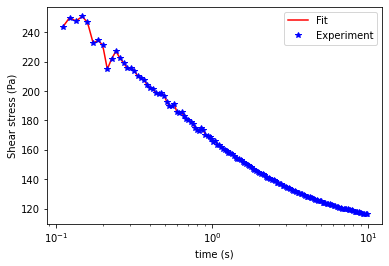

550
550
550
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


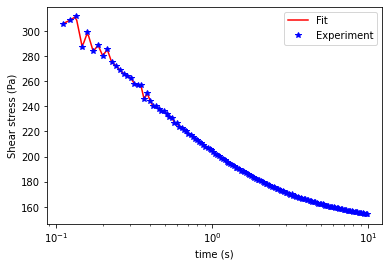

1100
1100
1100
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


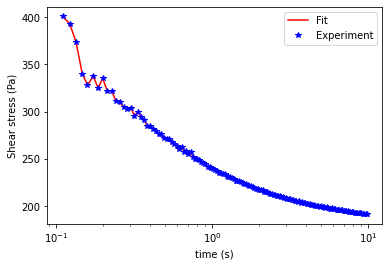

1650
1650
1650
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


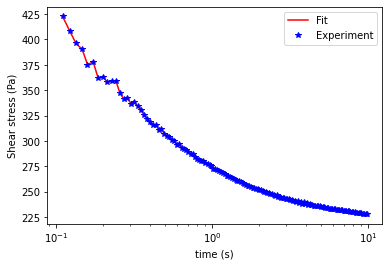

2200
2200
2200
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


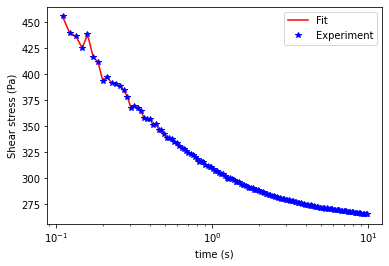

2750
2750
2750
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


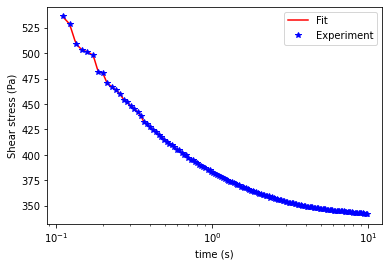

3300
3300
3300
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


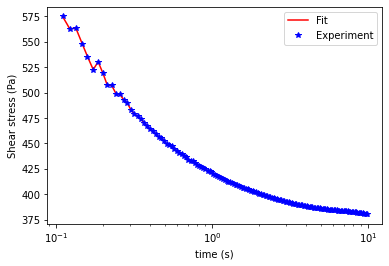

3850
3850
3850
[0.11  0.122 0.134 0.147 0.159 0.173 0.186 0.199 0.213 0.227 0.242 0.256
 0.271 0.286 0.302 0.318 0.334 0.35  0.367 0.384 0.402 0.419 0.437 0.456
 0.474 0.494 0.513 0.533 0.553 0.574 0.595 0.616 0.638 0.661 0.683 0.706
 0.73  0.754 0.779 0.804 0.829 0.855 0.881 0.908 0.936 0.964 0.992 1.022]
[1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381 1.418
 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87  1.916
 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484 2.542
 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257 3.329
 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228 4.319
 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449 5.564
 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984 7.128
 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914 9.096
 9.281 9.469 9.662 9.858]


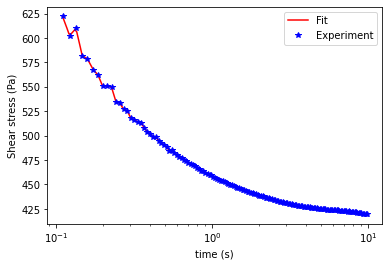

4400
4400
4400
[[0.01358025 0.0010248 ]
 [0.01358025 0.00140015]
 [0.01358025 0.0017755 ]
 ...
 [1.         0.99396293]
 [1.         0.99698147]
 [1.         1.        ]]


In [12]:
# time interval and shear interval of interest
timedomain = dde.geometry.TimeDomain(0,1) # non-dimensional end time
geom = dde.geometry.Interval(0,1) # non-dimensional shear rate
timexgeom = dde.geometry.GeometryXTime(geom, timedomain) # Creating time and geometry fields

# defining and initializing training model paramaters (to be determined by solving inverse problem)
G = dde.Variable(80.0) # 160 80.0
eta_s = dde.Variable(44.5)  # 100 44.5
k_plus = dde.Variable(1.0) # 0.5 1.0
k_minus = dde.Variable(1.0)  # 0.5 1.0
eta_p = dde.Variable(50.0)#50.0
yield_stress = dde.Variable(2.0)


# defining the TEVP rheology model
def pde(x,y):
    
    stress, struct_param = y[:,0:1], y[:,1:2]
    shear_rate, t = x[:,0:1], x[:,1:2]
    
    stress_rate = dde.grad.jacobian(y,x,i=0,j=1)
    struct_rate = dde.grad.jacobian(y,x,i=1,j=1)
    
    eqn1 = stress_rate - (G*del_time)/((eta_s+eta_p)*del_stress)* \
           (-stress*del_stress - stress_min + yield_stress*struct_param \
            + (eta_s + eta_p*struct_param)*(shear_rate*del_shear_rate+shear_min)) # removed exponent n 
    
    eqn2 = struct_rate - del_time*(k_plus*(1-struct_param) - k_minus*struct_param*(shear_rate*del_shear_rate+shear_min))
                                  
    return [eqn1,eqn2]


# training data
observe_x, shear_stress_training = gen_training_data() # observe_x gets shear rate and time 
print(observe_x)
observe_y1 = dde.PointSetBC(observe_x, shear_stress_training, component=0)  
# No observe_y2 as structure parameter not including in training data

# defining the data variable
data = dde.data.TimePDE(
    timexgeom,
    pde,
    [observe_y1],
    num_domain = 3000, 
    anchors = observe_x,
    num_test = 5000, 
    train_distribution='pseudo', 
)

In [13]:
layer_size = [2] + [10]*4 + [2] # NN architecture 
activation = "tanh"  # activation function
initializer = "Glorot normal" # Xavier initialization

# developing the Neural network
net = dde.nn.FNN(layer_size, activation, initializer)

# Output constraint to ensure structure parameter is between 0 and 1
def output_transform(x,y):
    return tf.concat((y[:,0:1], tf.sigmoid(y[:,1:2])), axis=1)
    

net.apply_output_transform(output_transform)

# developing the model
model = dde.Model(data,net)



In [14]:
# compiling the NN
model.compile("adam",
              lr=0.001, # learning rate
              loss_weights=[1,1,1e1],  # w_sigma, w_lambda, w_data
              external_trainable_variables=[G, eta_s, k_plus, k_minus, eta_p, yield_stress]) # Unknown model parameters to be determined

# extracting training parameters value any intermediate intervals and saving the file
variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus, eta_p, yield_stress], 
                                       period=1000, # Show output every 1000 epochs
                                       filename="variables_DOWTC5622_TEVP3_7s.dat") #File name where the parameters are stored


Compiling model...
Building feed-forward neural network...
'build' took 0.110927 s



C:\ProgramData\Anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.848711 s



Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.79e+01, 4.49e+02, 7.28e-01]    [2.07e+01, 4.92e+02, 7.28e-01]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1000      [7.47e-02, 5.42e-02, 7.12e-02]    [5.77e-02, 4.76e-02, 7.12e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
2000      [3.12e-02, 3.77e-02, 6.56e-02]    [2.40e-02, 3.30e-02, 6.56e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
3000      [1.28e-02, 2.94e-02, 6.05e-02]    [8.79e-03, 2.51e-02, 6.05e-02]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-3000.ckpt is not in all_model_ch

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-39000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
40000     [6.83e-05, 2.18e-05, 3.73e-03]    [4.99e-05, 2.19e-05, 3.73e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-40000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
41000     [7.07e-05, 2.15e-05, 3.69e-03]    [5.90e-05, 2.04e-05, 3.69e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-41000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
42000     [6.49e-05, 1.85e-05, 3.65e-03]    [5.05e-05, 1.80e-05, 3.65e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-42000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
43000     [6.28e-05, 1.70e-05, 3.61e-03]    [4.82e-05, 1.65e-05, 3.61e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-43000.ckpt is not

80000     [1.71e-03, 6.01e-04, 2.70e-03]    [1.81e-03, 6.24e-04, 2.70e-03]    []  
81000     [4.09e-05, 7.91e-06, 2.60e-03]    [3.13e-05, 6.04e-06, 2.60e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-81000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
82000     [4.10e-05, 7.83e-06, 2.58e-03]    [3.22e-05, 6.09e-06, 2.58e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-82000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
83000     [7.66e-04, 6.01e-04, 2.60e-03]    [8.23e-04, 6.16e-04, 2.60e-03]    []  
84000     [3.97e-05, 7.88e-06, 2.55e-03]    [3.05e-05, 5.92e-06, 2.55e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-84000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
85000     [5.81e-04, 4.21e-04, 2.57e-03]    [5.55e-04, 4.64e-04, 2.57e-03]    []  
86000     [3.89e-05, 7.71e-06, 2.52e-03]    [2.99e-05, 6.00e-06, 2.52e

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-124000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
125000    [3.46e-05, 7.48e-06, 2.13e-03]    [2.70e-05, 6.77e-06, 2.13e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-125000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
126000    [3.46e-05, 7.58e-06, 2.12e-03]    [2.66e-05, 6.57e-06, 2.12e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-126000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
127000    [3.43e-05, 7.53e-06, 2.12e-03]    [2.59e-05, 6.61e-06, 2.12e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-127000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
128000    [4.24e-05, 7.63e-06, 2.11e-03]    [3.54e-05, 6.62e-06, 2.11e-03]    []  
129000    [3.48e-05, 8.33e-06, 2.10e-03]    [2.69e-05, 7.11e-06, 2.10e-03]    []  
INFO:

173000    [3.39e-05, 6.79e-06, 1.94e-03]    [2.71e-05, 7.63e-06, 1.94e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-173000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
174000    [3.37e-05, 7.75e-06, 1.94e-03]    [2.67e-05, 7.39e-06, 1.94e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-174000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
175000    [3.41e-05, 6.88e-06, 1.94e-03]    [2.66e-05, 7.54e-06, 1.94e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-175000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
176000    [6.35e-04, 2.31e-04, 1.95e-03]    [6.36e-04, 2.37e-04, 1.95e-03]    []  
177000    [7.52e-05, 7.86e-06, 1.93e-03]    [7.01e-05, 8.75e-06, 1.93e-03]    []  
178000    [4.43e-05, 1.10e-05, 1.93e-03]    [3.83e-05, 1.36e-05, 1.93e-03]    []  
179000    [6.12e-05, 1.37e-05, 1.93e-03]    [5.67e-05, 1.65e-05, 1.

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-226000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
227000    [3.99e-05, 8.38e-06, 1.86e-03]    [3.49e-05, 9.86e-06, 1.86e-03]    []  
228000    [3.25e-05, 6.39e-06, 1.86e-03]    [2.56e-05, 6.46e-06, 1.86e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-228000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
229000    [3.81e-05, 1.54e-05, 1.85e-03]    [2.79e-05, 1.78e-05, 1.85e-03]    []  
230000    [7.96e-04, 2.53e-04, 1.88e-03]    [7.94e-04, 2.58e-04, 1.88e-03]    []  
231000    [4.58e-05, 4.52e-05, 1.85e-03]    [3.39e-05, 5.08e-05, 1.85e-03]    []  
232000    [4.25e-05, 8.28e-06, 1.85e-03]    [3.75e-05, 9.33e-06, 1.85e-03]    []  
233000    [1.09e-04, 4.09e-05, 1.85e-03]    [9.86e-05, 3.97e-05, 1.85e-03]    []  
234000    [3.20e-05, 7.35e-06, 1.85e-03]    [2.58e-05, 6.99e-06, 1.85e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-282000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
283000    [2.97e-05, 5.70e-06, 1.81e-03]    [2.55e-05, 4.53e-06, 1.81e-03]    []  
284000    [3.12e-03, 8.99e-04, 1.92e-03]    [3.24e-03, 9.55e-04, 1.92e-03]    []  
285000    [3.22e-05, 2.03e-05, 1.81e-03]    [2.32e-05, 2.15e-05, 1.81e-03]    []  
286000    [2.80e-05, 5.64e-06, 1.81e-03]    [2.26e-05, 4.69e-06, 1.81e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-286000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
287000    [7.90e-04, 2.17e-04, 1.83e-03]    [7.68e-04, 2.20e-04, 1.83e-03]    []  
288000    [2.89e-05, 7.91e-06, 1.81e-03]    [2.41e-05, 7.34e-06, 1.81e-03]    []  
289000    [2.83e-05, 6.05e-06, 1.81e-03]    [2.22e-05, 4.48e-06, 1.81e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-289000.ckpt is not in all_model_checkpoint_paths. Manu

334000    [3.20e-05, 9.72e-06, 1.76e-03]    [2.87e-05, 6.79e-06, 1.76e-03]    []  
335000    [2.68e-05, 8.14e-06, 1.76e-03]    [2.03e-05, 4.63e-06, 1.76e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-335000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
336000    [1.36e-04, 3.13e-05, 1.76e-03]    [1.17e-04, 2.88e-05, 1.76e-03]    []  
337000    [2.72e-05, 8.19e-06, 1.76e-03]    [2.09e-05, 4.74e-06, 1.76e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-337000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
338000    [2.71e-05, 8.34e-06, 1.76e-03]    [2.05e-05, 4.58e-06, 1.76e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-338000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
339000    [2.70e-05, 8.31e-06, 1.76e-03]    [2.09e-05, 4.68e-06, 1.76e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP

383000    [5.92e-05, 4.60e-04, 1.72e-03]    [5.07e-05, 4.71e-04, 1.72e-03]    []  
384000    [2.64e-05, 1.15e-05, 1.72e-03]    [1.93e-05, 5.14e-06, 1.72e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-384000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
385000    [2.65e-05, 1.25e-05, 1.72e-03]    [1.93e-05, 6.04e-06, 1.72e-03]    []  
386000    [3.61e-05, 1.28e-05, 1.72e-03]    [2.50e-05, 6.91e-06, 1.72e-03]    []  
387000    [2.60e-05, 1.14e-05, 1.71e-03]    [1.92e-05, 5.21e-06, 1.71e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-387000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
388000    [2.73e-05, 1.21e-05, 1.71e-03]    [2.29e-05, 5.50e-06, 1.71e-03]    []  
389000    [4.37e-04, 4.83e-05, 1.73e-03]    [4.61e-04, 4.15e-05, 1.73e-03]    []  
390000    [1.16e-04, 1.95e-05, 1.71e-03]    [9.32e-05, 1.36e-05, 1.71e-03]    []  
391000    [3.04e-05, 1.23e-05, 1.71e-03]    [2

439000    [3.06e-05, 1.89e-05, 1.67e-03]    [2.83e-05, 7.43e-06, 1.67e-03]    []  
440000    [2.04e-04, 4.42e-05, 1.67e-03]    [1.82e-04, 3.59e-05, 1.67e-03]    []  
441000    [2.55e-05, 1.81e-05, 1.67e-03]    [2.12e-05, 6.72e-06, 1.67e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-441000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
442000    [2.50e-05, 1.82e-05, 1.67e-03]    [1.93e-05, 6.76e-06, 1.67e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-442000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
443000    [3.23e-05, 1.81e-05, 1.67e-03]    [2.40e-05, 7.13e-06, 1.67e-03]    []  
444000    [2.52e-05, 1.83e-05, 1.67e-03]    [1.96e-05, 7.12e-06, 1.67e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-444000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
445000    [3.84e-05, 3.01e-05, 1.66e-03]    [2.78e-05, 1.82e-05, 1.

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-497000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
498000    [2.86e-05, 2.45e-05, 1.61e-03]    [2.56e-05, 1.02e-05, 1.61e-03]    []  
499000    [2.64e-05, 2.43e-05, 1.61e-03]    [2.05e-05, 1.02e-05, 1.61e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-499000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
500000    [2.62e-05, 2.43e-05, 1.61e-03]    [2.08e-05, 1.03e-05, 1.61e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-500000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
501000    [2.72e-05, 2.47e-05, 1.61e-03]    [2.06e-05, 1.07e-05, 1.61e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-501000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
502000    [2.59e-05, 2.45e-05, 1.61e-03]    [2.11e-05, 1.06e-05, 1.61e-03]    []  
INFO:

542000    [2.20e-05, 2.34e-05, 1.48e-03]    [1.88e-05, 1.18e-05, 1.48e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-542000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
543000    [2.14e-05, 2.30e-05, 1.47e-03]    [1.77e-05, 1.16e-05, 1.47e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-543000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
544000    [2.15e-05, 2.29e-05, 1.46e-03]    [1.80e-05, 1.12e-05, 1.46e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-544000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
545000    [2.13e-05, 2.16e-05, 1.45e-03]    [1.78e-05, 1.11e-05, 1.45e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-545000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
546000    [2.08e-05, 2.03e-05, 1.44e-03]    [1.74e-05, 1.12e-05, 1.44e-03]    []  
INFO:

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-581000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
582000    [1.66e-05, 1.33e-05, 1.28e-03]    [1.35e-05, 9.22e-06, 1.28e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-582000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
583000    [3.51e-05, 1.33e-05, 1.27e-03]    [3.27e-05, 8.92e-06, 1.27e-03]    []  
584000    [1.71e-05, 1.32e-05, 1.27e-03]    [1.41e-05, 9.00e-06, 1.27e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-584000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
585000    [1.64e-05, 1.26e-05, 1.27e-03]    [1.33e-05, 9.02e-06, 1.27e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-585000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
586000    [1.62e-05, 1.27e-05, 1.27e-03]    [1.26e-05, 8.95e-06, 1.27e-03]    []  
INFO:

627000    [1.29e-05, 1.18e-05, 1.18e-03]    [1.05e-05, 9.40e-06, 1.18e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-627000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
628000    [1.28e-05, 1.18e-05, 1.18e-03]    [1.02e-05, 9.50e-06, 1.18e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-628000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
629000    [1.28e-05, 1.16e-05, 1.18e-03]    [1.01e-05, 9.54e-06, 1.18e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-629000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
630000    [1.26e-05, 1.17e-05, 1.18e-03]    [1.00e-05, 9.29e-06, 1.18e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-630000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
631000    [1.24e-05, 1.19e-05, 1.18e-03]    [9.67e-06, 9.65e-06, 1.18e-03]    []  
INFO:

668000    [9.93e-06, 1.05e-05, 1.10e-03]    [7.71e-06, 8.99e-06, 1.10e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-668000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
669000    [2.12e-04, 1.45e-05, 1.11e-03]    [2.03e-04, 1.36e-05, 1.11e-03]    []  
670000    [9.74e-06, 1.03e-05, 1.10e-03]    [7.76e-06, 8.93e-06, 1.10e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-670000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
671000    [9.88e-06, 1.03e-05, 1.09e-03]    [7.49e-06, 8.85e-06, 1.09e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-671000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
672000    [8.49e-04, 1.73e-05, 1.12e-03]    [8.24e-04, 1.38e-05, 1.12e-03]    []  
673000    [2.60e-05, 1.08e-05, 1.09e-03]    [2.22e-05, 9.57e-06, 1.09e-03]    []  
674000    [9.65e-06, 9.96e-06, 1.09e-03]    [7.35e-06, 8.81e-06, 1.

713000    [8.66e-06, 8.70e-06, 1.02e-03]    [6.63e-06, 7.45e-06, 1.02e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-713000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
714000    [8.72e-06, 8.54e-06, 1.02e-03]    [6.68e-06, 7.37e-06, 1.02e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-714000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
715000    [8.72e-06, 8.58e-06, 1.01e-03]    [6.58e-06, 7.33e-06, 1.01e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-715000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
716000    [8.54e-06, 8.55e-06, 1.01e-03]    [6.23e-06, 7.21e-06, 1.01e-03]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-716000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
717000    [1.65e-04, 9.48e-06, 1.01e-03]    [1.60e-04, 7.51e-06, 1.01e-03]    []  
71800

762000    [7.65e-06, 7.43e-06, 9.44e-04]    [5.53e-06, 6.05e-06, 9.44e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-762000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
763000    [8.94e-06, 7.50e-06, 9.43e-04]    [6.45e-06, 6.16e-06, 9.43e-04]    []  
764000    [7.91e-06, 7.42e-06, 9.41e-04]    [5.66e-06, 6.21e-06, 9.41e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-764000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
765000    [7.57e-06, 7.39e-06, 9.40e-04]    [5.47e-06, 6.11e-06, 9.40e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-765000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
766000    [7.66e-06, 7.38e-06, 9.39e-04]    [5.60e-06, 6.07e-06, 9.39e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-766000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
76700

813000    [1.20e-05, 6.52e-06, 8.82e-04]    [8.90e-06, 5.31e-06, 8.82e-04]    []  
814000    [7.11e-06, 6.14e-06, 8.81e-04]    [4.96e-06, 5.11e-06, 8.81e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-814000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
815000    [7.03e-06, 6.23e-06, 8.80e-04]    [5.02e-06, 5.33e-06, 8.80e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-815000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
816000    [7.03e-06, 6.14e-06, 8.79e-04]    [5.06e-06, 5.14e-06, 8.79e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-816000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
817000    [1.02e-04, 7.23e-06, 8.79e-04]    [9.97e-05, 5.61e-06, 8.79e-04]    []  
818000    [7.01e-06, 6.18e-06, 8.77e-04]    [4.67e-06, 5.13e-06, 8.77e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP

861000    [6.72e-06, 5.27e-06, 8.34e-04]    [4.65e-06, 4.57e-06, 8.34e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-861000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
862000    [6.78e-06, 5.27e-06, 8.33e-04]    [4.70e-06, 4.59e-06, 8.33e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-862000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
863000    [6.79e-06, 5.21e-06, 8.32e-04]    [4.58e-06, 4.55e-06, 8.32e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-863000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
864000    [6.94e-06, 5.28e-06, 8.31e-04]    [4.74e-06, 4.58e-06, 8.31e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-864000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
865000    [3.25e-04, 1.73e-05, 8.33e-04]    [3.36e-04, 1.32e-05, 8.33e-04]    []  
86600

INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-907000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
908000    [6.42e-06, 4.76e-06, 7.95e-04]    [4.61e-06, 4.32e-06, 7.95e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-908000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
909000    [7.25e-06, 4.80e-06, 7.94e-04]    [5.26e-06, 4.54e-06, 7.94e-04]    []  
910000    [2.60e-05, 4.75e-06, 7.93e-04]    [2.33e-05, 4.30e-06, 7.93e-04]    []  
911000    [6.83e-06, 4.62e-06, 7.93e-04]    [4.85e-06, 4.24e-06, 7.93e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-911000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
912000    [3.68e-04, 5.98e-06, 8.00e-04]    [3.63e-04, 5.76e-06, 8.00e-04]    []  
913000    [6.28e-06, 4.65e-06, 7.91e-04]    [4.54e-06, 4.39e-06, 7.91e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP

957000    [1.36e-04, 4.65e-06, 7.63e-04]    [1.28e-04, 4.40e-06, 7.63e-04]    []  
958000    [6.24e-06, 4.51e-06, 7.60e-04]    [4.53e-06, 4.41e-06, 7.60e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-958000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
959000    [6.78e-06, 4.41e-06, 7.60e-04]    [5.10e-06, 4.39e-06, 7.60e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-959000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
960000    [1.91e-05, 4.39e-06, 7.59e-04]    [1.67e-05, 4.30e-06, 7.59e-04]    []  
961000    [6.14e-06, 4.48e-06, 7.58e-04]    [4.57e-06, 4.37e-06, 7.58e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-961000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
962000    [7.48e-06, 4.36e-06, 7.58e-04]    [5.58e-06, 4.26e-06, 7.58e-04]    []  
963000    [6.33e-06, 4.40e-06, 7.57e-04]    [4.60e-06, 4.49e-06, 7.

1005000   [9.63e-06, 4.47e-06, 7.32e-04]    [6.19e-06, 4.47e-06, 7.32e-04]    []  
1006000   [6.28e-06, 4.30e-06, 7.31e-04]    [4.97e-06, 4.63e-06, 7.31e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1006000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1007000   [6.23e-06, 4.38e-06, 7.30e-04]    [4.92e-06, 4.66e-06, 7.30e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1007000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1008000   [5.70e-04, 7.63e-06, 7.42e-04]    [5.53e-04, 7.78e-06, 7.42e-04]    []  
1009000   [7.22e-06, 4.64e-06, 7.30e-04]    [5.21e-06, 4.54e-06, 7.30e-04]    []  
1010000   [6.27e-06, 4.26e-06, 7.29e-04]    [4.68e-06, 4.56e-06, 7.29e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1010000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1011000   [1.09e-05, 4.48e-06, 7.28e-04]    [8.73e-06, 4.75e-06,

1059000   [1.15e-04, 4.37e-06, 7.08e-04]    [1.11e-04, 4.79e-06, 7.08e-04]    []  
1060000   [6.59e-06, 4.41e-06, 7.05e-04]    [5.24e-06, 4.84e-06, 7.05e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1060000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1061000   [1.85e-04, 9.94e-06, 7.07e-04]    [1.93e-04, 9.94e-06, 7.07e-04]    []  
1062000   [9.41e-05, 4.78e-06, 7.04e-04]    [8.84e-05, 4.69e-06, 7.04e-04]    []  
1063000   [7.08e-06, 4.28e-06, 7.03e-04]    [5.99e-06, 4.83e-06, 7.03e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1063000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1064000   [6.29e-06, 4.30e-06, 7.02e-04]    [5.27e-06, 5.00e-06, 7.02e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1064000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1065000   [7.27e-06, 4.31e-06, 7.02e-04]    [5.69e-06, 4.75e-06,

1111000   [4.09e-05, 1.33e-05, 6.81e-04]    [4.23e-05, 1.06e-05, 6.81e-04]    []  
1112000   [6.52e-06, 4.27e-06, 6.82e-04]    [5.18e-06, 5.09e-06, 6.82e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1112000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1113000   [6.91e-06, 4.33e-06, 6.81e-04]    [5.89e-06, 5.16e-06, 6.81e-04]    []  
1114000   [6.41e-06, 4.29e-06, 6.81e-04]    [5.24e-06, 4.94e-06, 6.81e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1114000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1115000   [6.45e-06, 4.31e-06, 6.80e-04]    [5.32e-06, 5.14e-06, 6.80e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1115000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1116000   [1.98e-05, 4.49e-06, 6.80e-04]    [1.91e-05, 5.32e-06, 6.80e-04]    []  
1117000   [2.57e-04, 4.90e-06, 6.83e-04]    [2.40e-04, 5.39e-06,

1168000   [1.48e-05, 4.60e-06, 6.60e-04]    [1.42e-05, 5.65e-06, 6.60e-04]    []  
1169000   [6.51e-06, 4.47e-06, 6.59e-04]    [5.36e-06, 5.18e-06, 6.59e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1169000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1170000   [6.83e-06, 4.45e-06, 6.59e-04]    [5.42e-06, 5.39e-06, 6.59e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1170000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1171000   [1.65e-05, 5.02e-06, 6.58e-04]    [1.53e-05, 5.38e-06, 6.58e-04]    []  
1172000   [6.58e-06, 4.51e-06, 6.58e-04]    [5.51e-06, 5.35e-06, 6.58e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1172000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1173000   [6.62e-06, 4.49e-06, 6.58e-04]    [5.35e-06, 5.41e-06, 6.58e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-T

1222000   [6.52e-06, 4.81e-06, 6.41e-04]    [5.32e-06, 5.55e-06, 6.41e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1222000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1223000   [1.01e-05, 4.81e-06, 6.41e-04]    [9.81e-06, 5.70e-06, 6.41e-04]    []  
1224000   [6.57e-06, 4.84e-06, 6.40e-04]    [5.51e-06, 5.65e-06, 6.40e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1224000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1225000   [6.38e-06, 4.76e-06, 6.40e-04]    [5.50e-06, 5.58e-06, 6.40e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1225000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1226000   [1.10e-05, 4.69e-06, 6.39e-04]    [8.81e-06, 5.84e-06, 6.39e-04]    []  
1227000   [3.13e-04, 5.36e-06, 6.44e-04]    [2.91e-04, 5.74e-06, 6.44e-04]    []  
1228000   [6.53e-06, 4.75e-06, 6.39e-04]    [5.40e-06, 5.64e-06,

1271000   [1.05e-04, 7.80e-06, 6.27e-04]    [1.00e-04, 7.14e-06, 6.27e-04]    []  
1272000   [6.58e-06, 5.54e-06, 6.27e-04]    [5.21e-06, 6.21e-06, 6.27e-04]    []  
1273000   [1.32e-04, 6.85e-06, 6.27e-04]    [1.25e-04, 6.42e-06, 6.27e-04]    []  
1274000   [1.03e-04, 5.83e-06, 6.28e-04]    [9.66e-05, 5.99e-06, 6.28e-04]    []  
1275000   [1.88e-04, 1.24e-05, 6.31e-04]    [1.50e-04, 1.20e-05, 6.31e-04]    []  
1276000   [6.41e-06, 5.10e-06, 6.25e-04]    [5.34e-06, 5.73e-06, 6.25e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1276000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1277000   [8.71e-06, 5.33e-06, 6.25e-04]    [8.43e-06, 6.15e-06, 6.25e-04]    []  
1278000   [6.84e-06, 5.11e-06, 6.25e-04]    [5.60e-06, 5.91e-06, 6.25e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1278000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1279000   [6.50e-06, 5.19e-06, 6.25e-04]    

1332000   [7.02e-06, 5.67e-06, 6.11e-04]    [5.91e-06, 6.06e-06, 6.11e-04]    []  
1333000   [4.20e-05, 1.49e-05, 6.12e-04]    [2.87e-05, 1.37e-05, 6.12e-04]    []  
1334000   [1.07e-05, 1.16e-05, 6.10e-04]    [7.66e-06, 1.01e-05, 6.10e-04]    []  
1335000   [1.76e-04, 7.96e-06, 6.13e-04]    [1.82e-04, 8.37e-06, 6.13e-04]    []  
1336000   [6.86e-06, 5.60e-06, 6.10e-04]    [5.90e-06, 6.13e-06, 6.10e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1336000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1337000   [1.23e-05, 5.58e-06, 6.10e-04]    [9.88e-06, 5.98e-06, 6.10e-04]    []  
1338000   [4.96e-05, 5.81e-06, 6.11e-04]    [5.08e-05, 6.50e-06, 6.11e-04]    []  
1339000   [2.23e-04, 5.56e-06, 6.13e-04]    [2.04e-04, 6.19e-06, 6.13e-04]    []  
1340000   [6.39e-06, 5.54e-06, 6.09e-04]    [5.08e-06, 6.12e-06, 6.09e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1340000.ckpt is not in all_model

1387000   [6.15e-06, 5.80e-06, 5.98e-04]    [4.74e-06, 6.05e-06, 5.98e-04]    []  
1388000   [1.26e-05, 5.89e-06, 5.98e-04]    [9.86e-06, 6.16e-06, 5.98e-04]    []  
1389000   [7.16e-06, 5.91e-06, 5.98e-04]    [5.79e-06, 6.00e-06, 5.98e-04]    []  
1390000   [7.34e-05, 6.13e-06, 5.99e-04]    [7.37e-05, 6.42e-06, 5.99e-04]    []  
1391000   [1.10e-05, 6.98e-06, 5.97e-04]    [9.13e-06, 6.78e-06, 5.97e-04]    []  
1392000   [6.87e-06, 5.82e-06, 5.97e-04]    [5.86e-06, 6.09e-06, 5.97e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1392000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1393000   [5.98e-06, 5.89e-06, 5.97e-04]    [4.76e-06, 5.98e-06, 5.97e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1393000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1394000   [1.14e-05, 5.92e-06, 5.97e-04]    [1.09e-05, 6.17e-06, 5.97e-04]    []  
1395000   [6.41e-06, 5.82e-06, 5.97e-04]    

1446000   [5.88e-06, 6.03e-06, 5.86e-04]    [4.52e-06, 6.26e-06, 5.86e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1446000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1447000   [1.04e-04, 6.79e-06, 5.88e-04]    [7.62e-05, 6.62e-06, 5.88e-04]    []  
1448000   [2.16e-03, 1.15e-05, 6.15e-04]    [2.09e-03, 1.03e-05, 6.15e-04]    []  
1449000   [7.11e-06, 6.38e-06, 5.86e-04]    [5.29e-06, 6.30e-06, 5.86e-04]    []  
1450000   [1.20e-05, 6.32e-06, 5.86e-04]    [1.09e-05, 6.24e-06, 5.86e-04]    []  
1451000   [5.95e-06, 6.18e-06, 5.85e-04]    [4.47e-06, 6.13e-06, 5.85e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1451000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1452000   [1.97e-05, 6.03e-06, 5.85e-04]    [1.74e-05, 6.29e-06, 5.85e-04]    []  
1453000   [6.04e-06, 6.15e-06, 5.85e-04]    [4.38e-06, 6.15e-06, 5.85e-04]    []  
INFO:tensorflow:model-DOWTC5622-TEVP-final3-

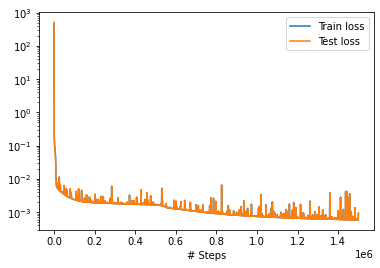

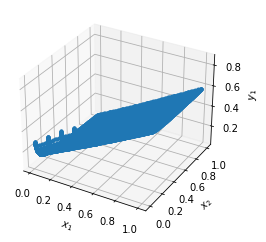

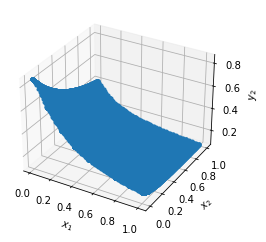

In [15]:

# Saving model at intermediate steps #
checkpointer = dde.callbacks.ModelCheckpoint(
     "model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3", verbose=0, save_better_only=True
 )

# Resampling PDE loss data points #
resampler = dde.callbacks.PDEResidualResampler(period=1000)

# Training the model #
losshistory, trainstate = model.train(epochs = 1500000, callbacks = [variable, checkpointer, resampler],model_save_path='C/model-DOWTC5622-TEVP-final3-7s') 

# Saving train and test error plots #
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)



In [17]:
# experimental data to validate the model results at unseen 7/s data #

valPoints = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=6,skiprows=range(148,296))

t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]

shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


# Non-dimensionalizing #
t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

# using model to predict shear stress at a new shear rate #
test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
#print(test_data_set)

test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # Predicting shear stress
test_struct_param = model.predict(test_data_set,operator=lambda x,y: y[:,1:2]) # Predicting strcuture parameter

# making non-dimensional to dimensional
test_shear_stress = test_shear_stress*(del_stress) + stress_min

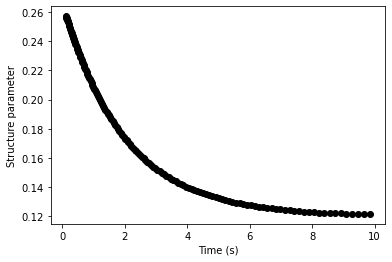

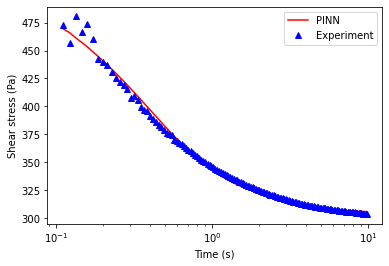

In [18]:
# Plotting structure parameter with time #
plt.figure()
plt.plot(t_expt1,test_struct_param, 'ok', label='PINN-Structure-Parameter')
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Structure parameter')
plt.show()

# Plotting shear stress with time #
plt.figure()
plt.plot(t_expt1,test_shear_stress, '-r', label='PINN')
plt.plot(t_expt1,shear_stress1, '^b', label='Experiment')
plt.legend()
plt.xscale('log')
#plt.title('8/s - prediction')
plt.xlabel('Time (s)')
plt.ylabel('Shear stress (Pa)')
plt.show()


In [16]:
# Restore the saved model with the smallest training loss - Run initial steps until compilation
# enter the correct model number
model.restore(f"model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1499000.ckpt", verbose=1)


Restoring model from model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1499000.ckpt ...

INFO:tensorflow:Restoring parameters from model-DOWTC5622-TEVP-final3-7s/model-DOWTC5622-TEVP-final3-1499000.ckpt


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


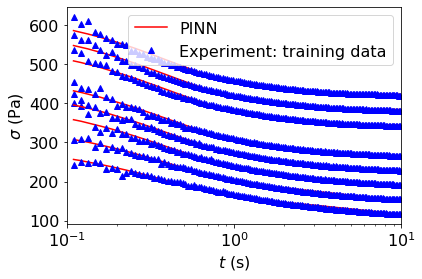

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


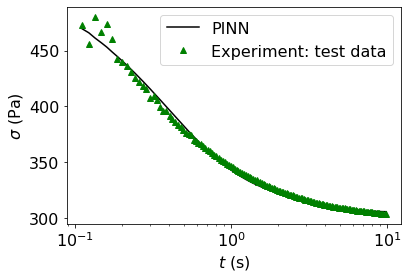

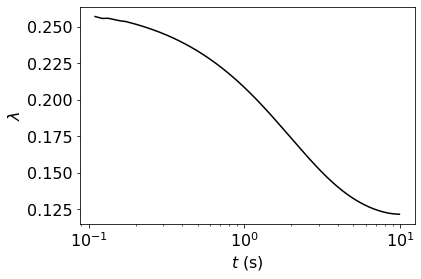

In [20]:
# Plotting training and test data for manuscript #

plt.rcParams.update({'font.size': 16})

for itrnew in range(1,10):
    if itrnew == 6: # skipping 7/s data
        continue
    valPoints = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itrnew,skiprows=range(148,296))
    
    t_expt1 = np.array(valPoints["t"])
    t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

    gammadot1 = np.array(valPoints["shear rate"])
    gammadot1 = gammadot1[:,np.newaxis]

    shear_stress1 = np.array(valPoints["shear stress"])
    shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


    t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
    gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

    # using model to predict shear stress at a new shear rate #

    test_data_set = np.hstack((gammadot_non_dim,t_non_dim))

    test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
    #test_struct_param = model.predict(test_data_set,operator=lambda x,y: y[:,1:2])
    # making non-dimensional to dimensional
    test_shear_stress = test_shear_stress*(del_stress) + stress_min
    
    
    #plt.figure()
    if itrnew == 1:
        plt.plot(t_expt1,test_shear_stress, '-r', label='PINN')
        plt.plot(t_expt1,shear_stress1, '^b', label='Experiment: training data')
    elif itrnew == 6:
        plt.plot(t_expt1,test_shear_stress, '-k', label='PINN: prediction '+str(itrnew+1)+'/s')
        plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data '+str(itrnew+1)+'/s')
    else:
        plt.plot(t_expt1,test_shear_stress, '-r')
        plt.plot(t_expt1,shear_stress1, '^b')

plt.xlim([0.1, 10])
plt.legend(loc='upper right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_trainingdata_DOW5622_latest.eps',format='eps',bbox_inches='tight')
plt.show()

valPoints = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=6,skiprows=range(148,296))
    
t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]

shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

    # using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # only predicting the shear stress and not struct param
test_shear_stress = test_shear_stress*(del_stress) + stress_min

plt.plot(t_expt1,test_shear_stress, '-k', label='PINN')
plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data')
    
# plt.figure()
#plt.xlim([0.1, 10])
plt.legend(loc='upper right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_testdata_DOW5622_7s_latest.eps',format='eps',bbox_inches='tight')
plt.show()

# Plotting lambda vs t 

test_lambda = model.predict(test_data_set,operator=lambda x,y: y[:,1:2]) # only predicting the shear stress and not struct param

plt.plot(t_expt1,test_lambda, '-k')
    
# plt.figure()
#plt.xlim([0.1, 10])
#plt.legend(loc='upper right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\lambda$',fontsize=16)
plt.savefig('Lambda_testdata_DOW5622_7s_latest.eps',format='eps',bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


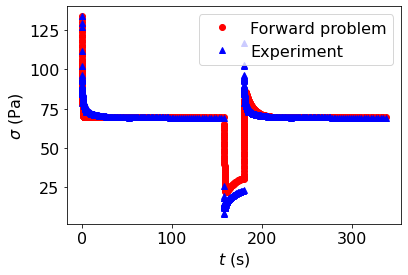

In [21]:
### Solving direct problem based on odeint for validation purposes ###
plt.rcParams.update({'font.size': 16})

from scipy.integrate import odeint

# Enter correct file name 
valPoints1 = pd.read_excel('DOW5622_lowShearRates_101222.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=5)
t_expt2 = np.array(valPoints1["t"])
t_expt2 = t_expt2[:,np.newaxis] # Converting to a column vector

gammadot2 = np.array(valPoints1["shear rate"])
gammadot2 = gammadot2[:,np.newaxis]

shear_stress2 = np.array(valPoints1["shear stress"])
shear_stress2 = shear_stress2[:,np.newaxis] # experiment value


def dydt(y,t,G,eta_s,eta_p,k_plus,k_minus,yield_stress):
    
    shear_rate_ode = (1-np.heaviside(t-158.25,1))*1.0 + (np.heaviside(t-158.25,1)-np.heaviside(t-180.042,1))*0.1 \
    + (np.heaviside(t-180.073,1)-np.heaviside(t-338.292,1))*1.0
    
    y1, y2 = y
    dydt = [(G/(eta_s+eta_p))*(-y1 + yield_stress*y2 + (eta_s + eta_p*y2)*shear_rate_ode), k_plus*(1-y2) - k_minus*y2*shear_rate_ode]
    return dydt

t = t_expt2.reshape(np.size(t_expt2),) #Non-dimensional time
y0 = [133.79,0.5] # setting IC for shear stress and structure parameter

# Assign optimized model parameters from PINN
G_ode = 190.0 
eta_s_ode = 39.4 
eta_p_ode = 30.8 
k_plus_ode = 0.061 
k_minus_ode = 0.063
yield_stress_ode = 30.5 


stress_ode = odeint(dydt,y0,t,args=(G_ode,eta_s_ode,eta_p_ode,k_plus_ode,k_minus_ode,yield_stress_ode))

plt.plot(t_expt2,stress_ode[:,0], 'or', label='Forward problem') 
plt.plot(t_expt2,shear_stress2, '^b', label='Experiment')
plt.legend()

plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('StepStrain_Val_DOW5622_latest.eps',format='eps',bbox_inches='tight')
plt.show()

Compiling model...
'compile' took 0.507090 s

Training model...

1500091   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000252
  Number of iterations: 1
  Number of functions evaluations: 18
1500109   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  

Best model at step 1500091:
  train loss: 2.52e-04
  test loss: 2.52e-04
  test metric: []

'train' took 1.818854 s

Saving loss history to C:\Users\pnagrani\loss.dat ...
Saving training data to C:\Users\pnagrani\train.dat ...
Saving test data to C:\Users\pnagrani\test.dat ...


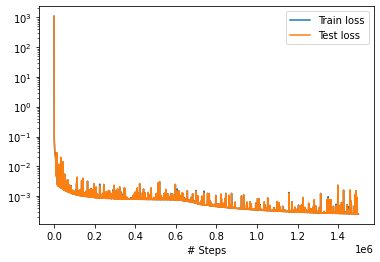

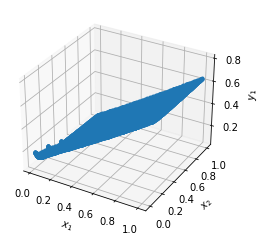

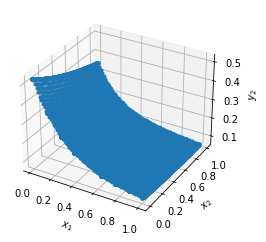

Compiling model...
'compile' took 0.630434 s

Training model...

Step      Train loss                        Test loss                         Test metric
1500109   [2.03e-06, 2.45e-06, 2.48e-05]    [2.54e-06, 2.18e-06, 2.48e-05]    []  

Best model at step 1500109:
  train loss: 2.93e-05
  test loss: 2.95e-05
  test metric: []

'train' took 0.628264 s



In [37]:
# If needed can perform further training using L-BFGS optimizer. We skipped as it did not improve the loss significantly #

model.compile("L-BFGS-B",
              loss_weights=[1,1,1e1],
              external_trainable_variables=[G, eta_s, k_plus, k_minus])

model.train_step.optimizer_kwargs = {'options': {'maxfun': 1e5, 'ftol': 1e-20, 'gtol': 1e-20,'eps': 1e-20, 'iprint': -1, 'maxiter': 1e5}}

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=10, filename="variables1-7s_DOWTC5622_LBFGSB.dat")
losshistory, trainstate = model.train(callbacks = [variable])
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=1, filename="dummy-4s.txt")
model.compile("adam", lr=0, external_trainable_variables=[G, eta_s, k_plus, k_minus])
losshistory2, train_state2 = model.train(epochs=0, callbacks=[variable], display_every=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


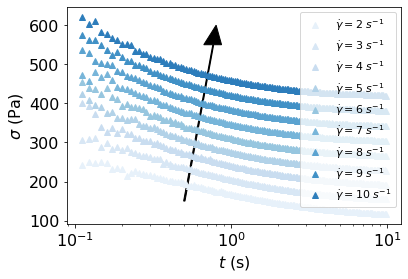

In [50]:
# Generating plot of experimental data - Not a part of PINN process #

plt.rcParams.update({'font.size': 16})
cmap = plt.colormaps['Blues']

for itr in range(1,10): 
    
    t_expt = []
    gammadot = []
    shear_stress = []
   
    startUpFlow = pd.read_excel('DOWTC5622-09-02-22.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itr, skiprows=range(148,296))
    # Reading data from sheet number - itr
    t_expt = np.array(startUpFlow["t"])
    #gammadot = np.array(startUpFlow["shear rate"])
    shear_stress = np.array(startUpFlow["shear stress"])
    
    plt.plot(t_expt,shear_stress,color=cmap(itr*20), label='$\dot\gamma = $' +str(itr+1)+' $ s^{-1}$',marker='^',linestyle = 'None')
     
plt.arrow(0.5,150,0.3,450, fc="k",ec='k',width=0.01,length_includes_head='True',head_length=50,head_width=0.2)
plt.legend(loc='upper right',prop={'size': 11})
plt.xscale('log')
#plt.ylim([0, 800])
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
#plt.savefig('Shear_stress_experiment_DOW5622.eps',format='eps',bbox_inches='tight')
plt.show()

        
       
